In [1]:
%reload_ext autoreload
%autoreload
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import sys
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms


In [3]:
sz=224
batch_size=16

In [4]:
Data_DIR ="D:/AI_Machinlearning/datasets/friuts/final_data/"



In [5]:
os.listdir(Data_DIR )

['test', 'train', 'valid']

In [6]:
train_dir=f"{Data_DIR}train"


In [7]:
os.listdir(train_dir)

['apple_6',
 'apple_braeburn_1',
 'apple_crimson_snow_1',
 'apple_golden_1',
 'apple_golden_2',
 'apple_golden_3',
 'apple_granny_smith_1',
 'apple_hit_1',
 'apple_pink_lady_1',
 'apple_red_1',
 'apple_red_2',
 'apple_red_3',
 'apple_red_delicios_1',
 'apple_red_yellow_1',
 'apple_rotten_1',
 'cabbage_white_1',
 'carrot_1',
 'cucumber_1',
 'cucumber_3',
 'eggplant_violet_1',
 'pear_1',
 'pear_3',
 'zucchini_1',
 'zucchini_dark_1']

In [8]:
valid_dir=f"{Data_DIR}valid"

53

In [12]:
trn_fnames=glob.glob(f"{train_dir}/*/*.jpg")
                     
trn_fnames[:5]             

['D:/AI_Machinlearning/datasets/friuts/final_data/train\\apple_6\\r0_0.jpg',
 'D:/AI_Machinlearning/datasets/friuts/final_data/train\\apple_6\\r0_10.jpg',
 'D:/AI_Machinlearning/datasets/friuts/final_data/train\\apple_6\\r0_100.jpg',
 'D:/AI_Machinlearning/datasets/friuts/final_data/train\\apple_6\\r0_102.jpg',
 'D:/AI_Machinlearning/datasets/friuts/final_data/train\\apple_6\\r0_104.jpg']

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
(252, 311, 3)


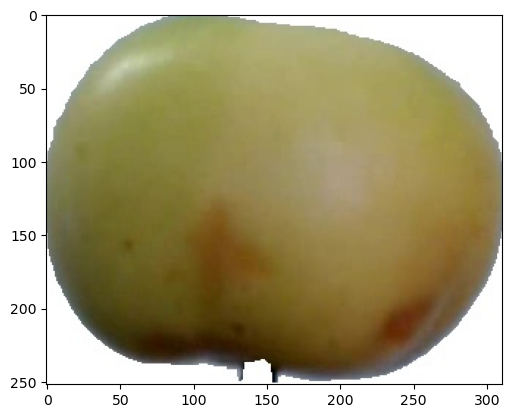

In [13]:
img=plt.imread(trn_fnames[8])
print(img)
print(img.shape)
plt.imshow(img)           # تا اینجا مسیرها را از هم تفکیک کردیم و نمایش دادیم در مرحله بعد میریم سراغ تعریق دیتا ترین

# data augmentation

In [14]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{Data_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{Data_DIR}valid', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True,  num_workers=8)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 6231
Valid size: 3114 (0.33)


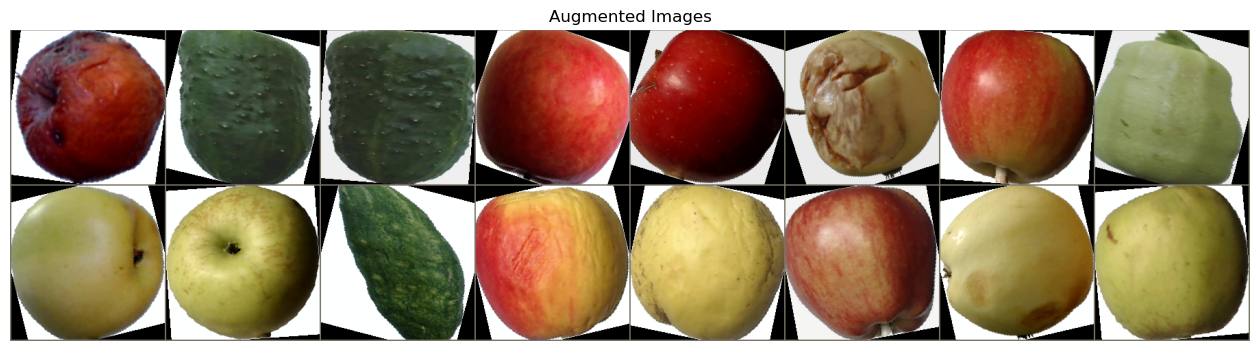

In [31]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

In [15]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56 * 56 * 32,24)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)    just for plot
        out = self.fc(out)
        return out

In [16]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)



In [17]:
torch.cuda.is_available()

True

In [18]:
display(model)

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=24, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)


# Train

In [21]:
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # forwad pass
        outputs = model(inputs)      #model.forward(inputs) ?
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))


Epoch [ 1/ 5], Step [ 50/389], Loss: 0.2613
Epoch [ 1/ 5], Step [100/389], Loss: 0.0827
Epoch [ 1/ 5], Step [150/389], Loss: 0.5218
Epoch [ 1/ 5], Step [200/389], Loss: 0.1085
Epoch [ 1/ 5], Step [250/389], Loss: 0.0267
Epoch [ 1/ 5], Step [300/389], Loss: 0.1294
Epoch [ 1/ 5], Step [350/389], Loss: 0.2615
Epoch [ 2/ 5], Step [ 50/389], Loss: 0.0875
Epoch [ 2/ 5], Step [100/389], Loss: 0.3327
Epoch [ 2/ 5], Step [150/389], Loss: 0.0620
Epoch [ 2/ 5], Step [200/389], Loss: 0.0158
Epoch [ 2/ 5], Step [250/389], Loss: 0.0373
Epoch [ 2/ 5], Step [300/389], Loss: 0.0848
Epoch [ 2/ 5], Step [350/389], Loss: 0.0286
Epoch [ 3/ 5], Step [ 50/389], Loss: 0.0159
Epoch [ 3/ 5], Step [100/389], Loss: 0.0340
Epoch [ 3/ 5], Step [150/389], Loss: 0.0341
Epoch [ 3/ 5], Step [200/389], Loss: 0.0475
Epoch [ 3/ 5], Step [250/389], Loss: 0.0329
Epoch [ 3/ 5], Step [300/389], Loss: 0.0333
Epoch [ 3/ 5], Step [350/389], Loss: 0.0013
Epoch [ 4/ 5], Step [ 50/389], Loss: 0.0161
Epoch [ 4/ 5], Step [100/389], L

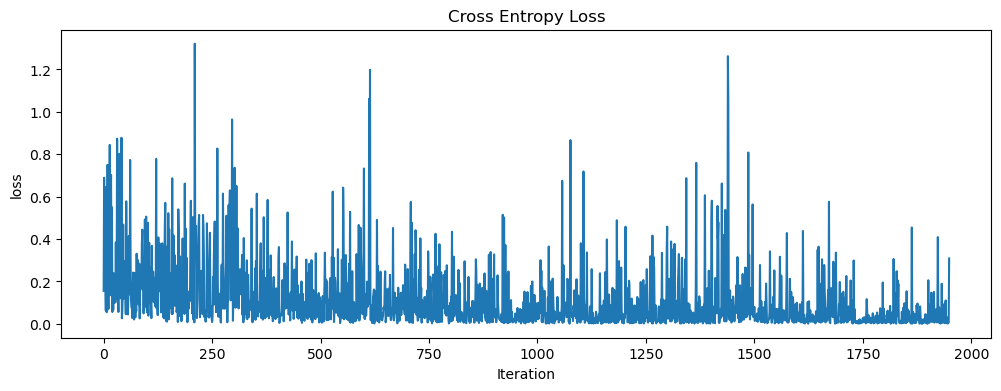

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

# Accuracy on validation data


In [23]:
def evaluate_model(model, dataloader, device):
    model.eval()               # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [24]:
evaluate_model(model, valid_dl, device)

accuracy: 99.29


In [25]:
evaluate_model(model, train_dl, device)

accuracy: 99.12


In [26]:
def visualize_model(model, dataloader, device, num_images=6):
    """ Visulaize the prediction of the model on a bunch of random data.
    """
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10., 8.))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)

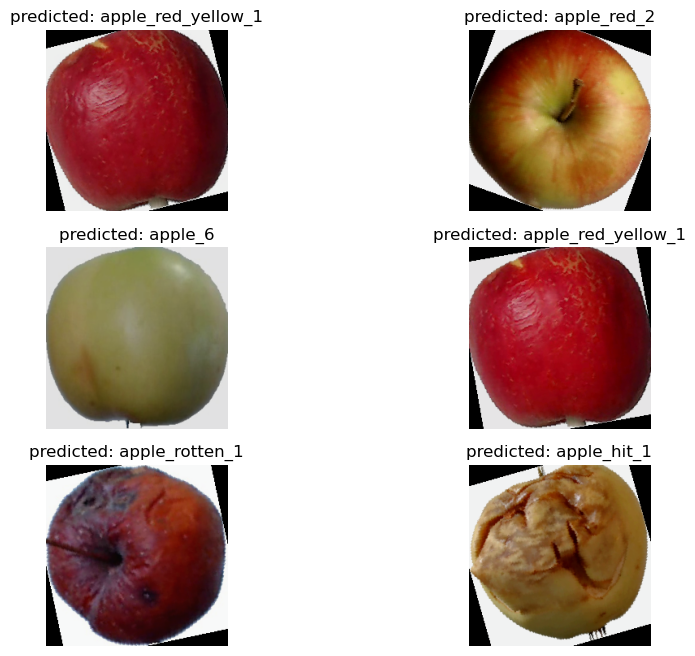

In [28]:
visualize_model(model, train_dl, device)

In [29]:
def plot_errors(model, dataloader, device):
    model.eval()
    plt.figure(figsize=(12, 24))
    count = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            incorrect_idxs = np.flatnonzero(preds.cpu().numpy() != labels.cpu().numpy())

            for idx in incorrect_idxs:
                count += 1
                if count > 30: break
                ax = plt.subplot(10, 3, count)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[idx]]))
                imshow(inputs.cpu().data[idx])
    
    plt.show()

    print("{} images out of {} were misclassified.".format(count, len(dataloader.dataset)))

100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [00:34<00:00,  5.69it/s]


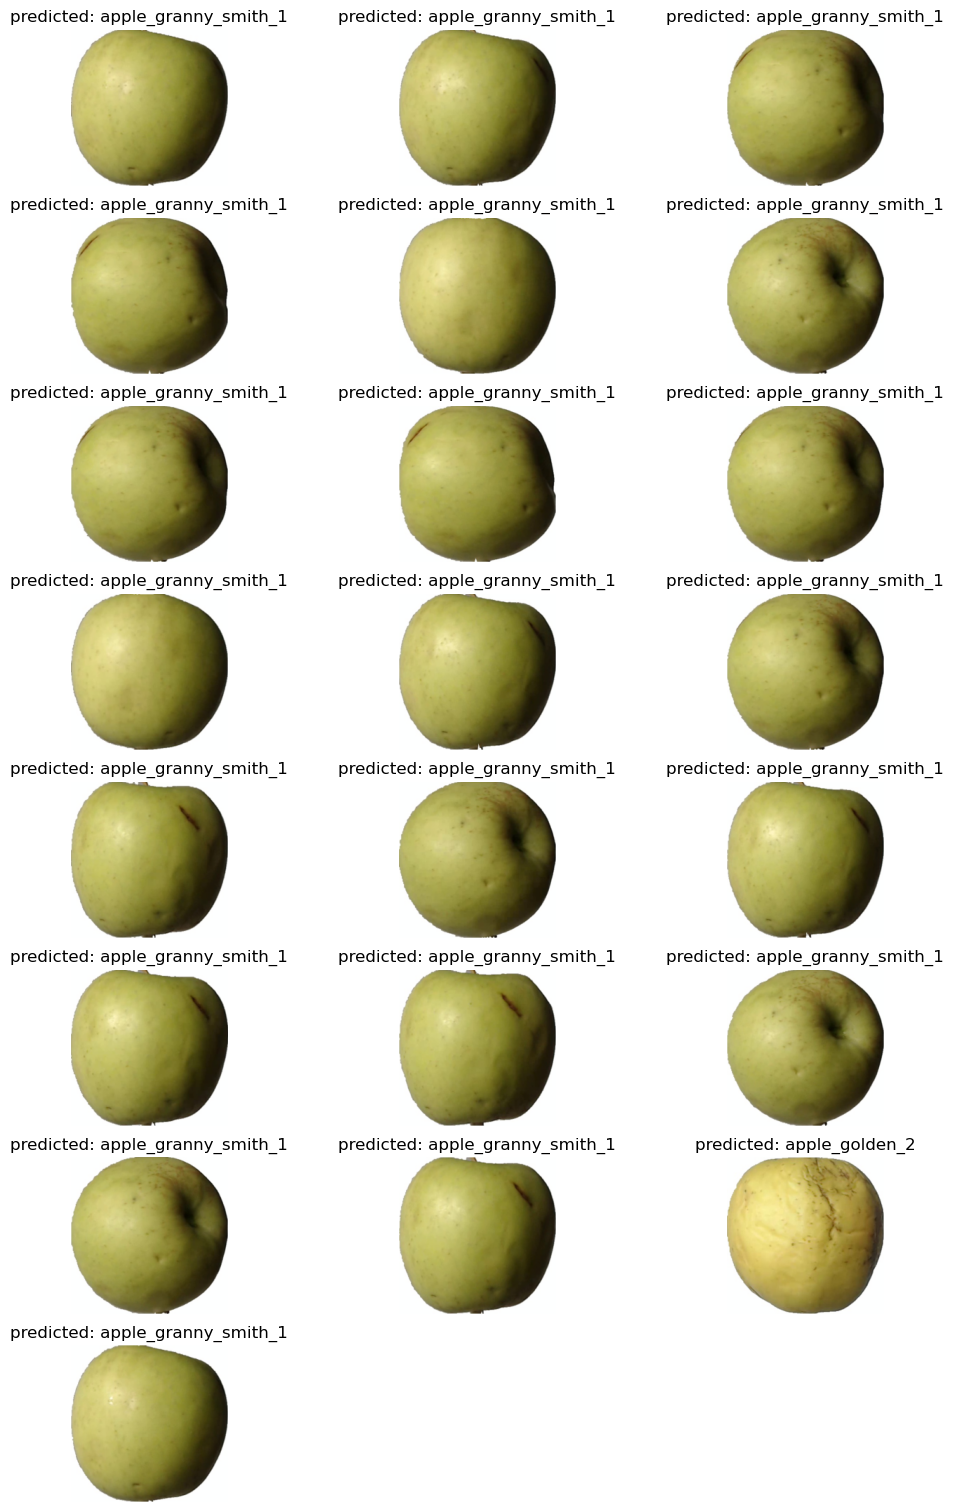

22 images out of 3114 were misclassified.


In [30]:
plot_errors(model, valid_dl, device)